In [1]:
import re 
import os 

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

In [2]:
class file: 
    
    def __init__(self, demo_file, health_file, year_str): 
        self.name = year_str 
        self.demo = demo_file 
        self.health = health_file
        
    def __repr__(self):
        return self.name
    
    __str__ = __repr__ 
    
    @property
    def tar(self):
        return self.health['SMD100TR']
    
    @property
    def tar_weighted(self):
        return self.tar * self.weight['WTINT2YR']

    @property
    def weight(self):
        return self.demo[['RIDAGEYR', 'WTINT2YR']]
    
    def __getitem__(self, index): 
        return self.health[index]

def weighted_value(source_col, weight_col, percentage=True):
    unique_values = source_col.unique()
    mapping_dict = {}
    
    for value in unique_values: 
        binary = source_col == value
        weighted = binary * weight_col
        result = round(weighted.sum() / weight_col.sum(), 5) if percentage else weighted.sum()
        mapping_dict[value] = result
    return mapping_dict

year_mapping = {letter: f'{year}-{year+1}' for year, letter in enumerate('A B C D E F G H I J K L', 1999)}

In [3]:
records = [] 

year_regex = re.compile(r'.*_([A-Z]{1}).*')

files = list(filter(lambda item: item.endswith('XPT'), os.listdir('data')))
files.sort(key=lambda item: year_regex.search(item).groups()[0])

for index in range(0, len(files), 2):
    filename1, filename2 = files[index], files[index+1]
    print(filename1, filename2)
    year = year_mapping[year_regex.search(filename1).groups()[0]]
    file1, file2 = pd.read_sas(f'data/{filename1}'), pd.read_sas(f'data/{filename2}')
    package = (file1, file2) if 'DEMO' in filename1 else (file2, file1)
    package = file(*package, year)
    package.tar_weighted
    records.append(package)

DEMO_A.XPT SMQ_A.XPT
DEMO_B.XPT SMQ_B.XPT
DEMO_C.XPT SMQ_C.XPT
DEMO_D.XPT SMQ_D.XPT
DEMO_E.XPT SMQ_E.XPT
DEMO_F.XPT SMQ_F.XPT
DEMO_G.XPT SMQ_G.XPT
DEMO_H.XPT SMQ_H.XPT
DEMO_I.XPT SMQ_I.XPT
DEMO_J.XPT SMQ_J.XPT


        year  response  percentage
0  1999-2000       895       0.183
1  2001-2002       992       0.183
2  2003-2004       955       0.189
3  2005-2006       956       0.133
4  2007-2008       934       0.131
5  2009-2010       922       0.122
6  2011-2012       825       0.122
7  2013-2014       828       0.116
8  2015-2016       752       0.107
9  2017-2018       695       0.103


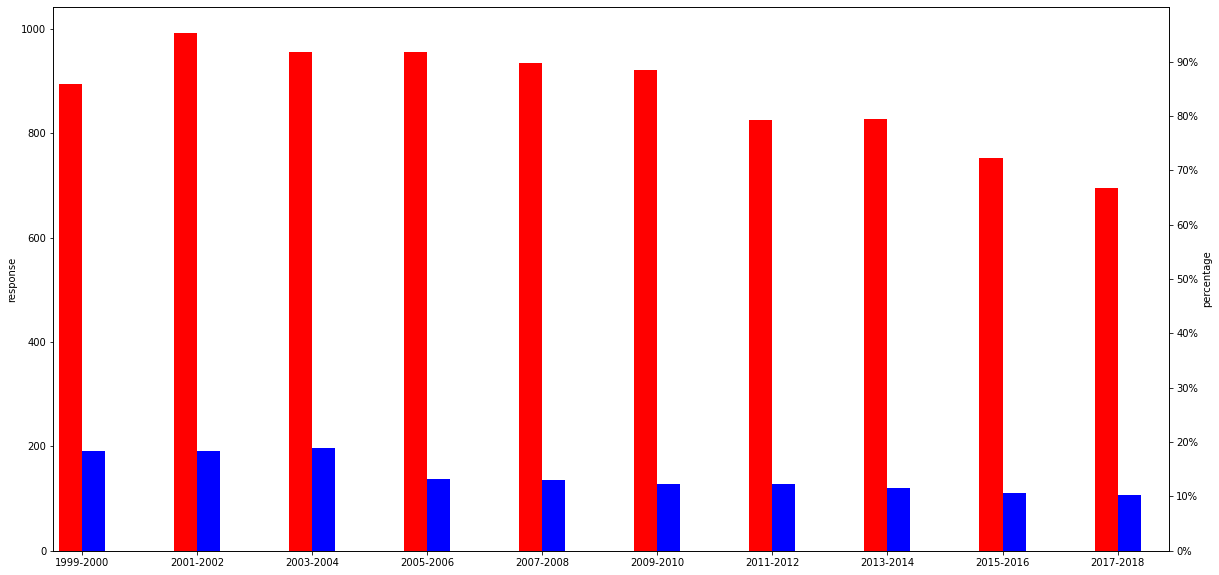

In [4]:
data = [(table.name, table.health.shape[0], table.tar.notna().sum()) for table in records]
data = [(name, response, round(response/total, 3)) for name, total, response in data]
table = pd.DataFrame(columns=['year', 'response', 'percentage'], data=data)

print(table)

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.2

table.response.plot(kind='bar', color='red', ax=ax, width=width, position=1)
table.percentage.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('response')
ax2.set_ylabel('percentage')
ax2.set_ylim(0, 1)

ticks = np.arange(0, 1, 0.1)
ax2.set_yticks(ticks)
ax2.set_yticklabels([f'{number:.0%}' for number in ticks])

ax.set_xticklabels(table['year'], rotation=0)

plt.show()

In [5]:
tar = {table.name:table.health[table.tar.notna()]['SMD100TR'] for table in records}

distribution = [[name, series.mean(), series.median(), series.std()] for name, series in tar.items()]
table = pd.DataFrame(columns=['year', 'mean', 'median', 'std'], data=distribution)

table

,year,mean,median,std
0,1999-2000,12.791061,14.0,4.078635
1,2001-2002,12.841734,14.0,4.082172
2,2003-2004,12.659686,12.0,4.051089
3,2005-2006,11.826360,12.0,4.739847
4,2007-2008,12.962527,13.0,3.616932
5,2009-2010,13.542299,14.0,3.679749
6,2011-2012,14.215758,15.0,3.726316
7,2013-2014,12.983092,13.0,2.229776
8,2015-2016,13.018617,14.0,2.374336
9,2017-2018,12.956835,13.0,2.387740


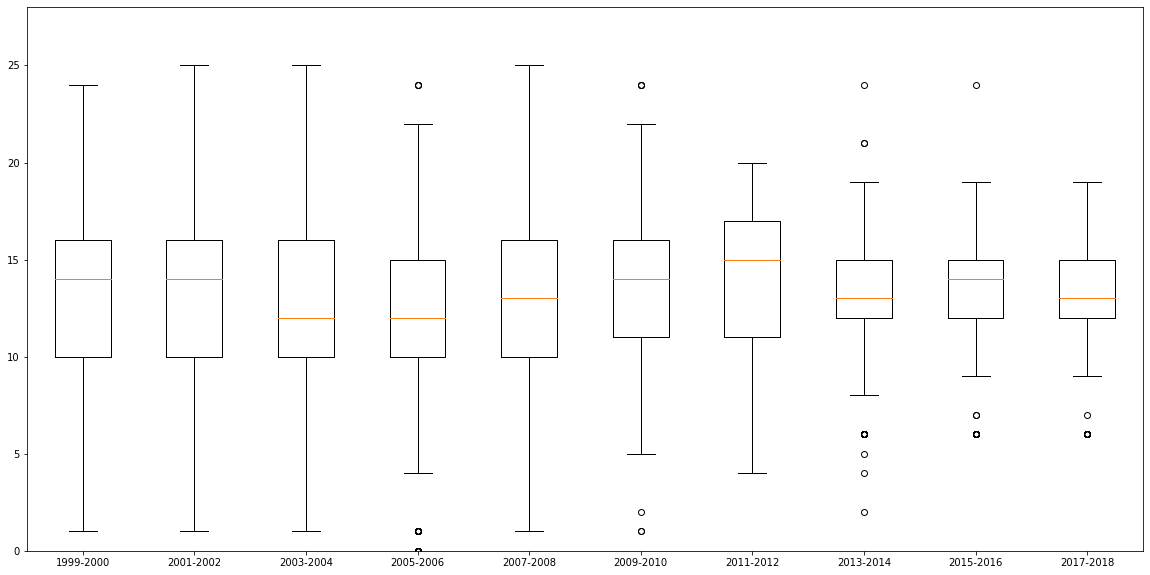

In [6]:
figure, axis = plt.subplots(figsize=(20, 10))

tar = {table.name:table.health[table.tar.notna()]['SMD100TR'] for table in records}

axis.boxplot(tar.values(), vert=True)
axis.set_xticklabels(tar.keys())

plt.ylim(0, 28)
plt.show()

k=0.07330384970145326, b=12.576625631909607, r=0.36464986170220326, p=0.3002002131540707, std=0.06617941419674483


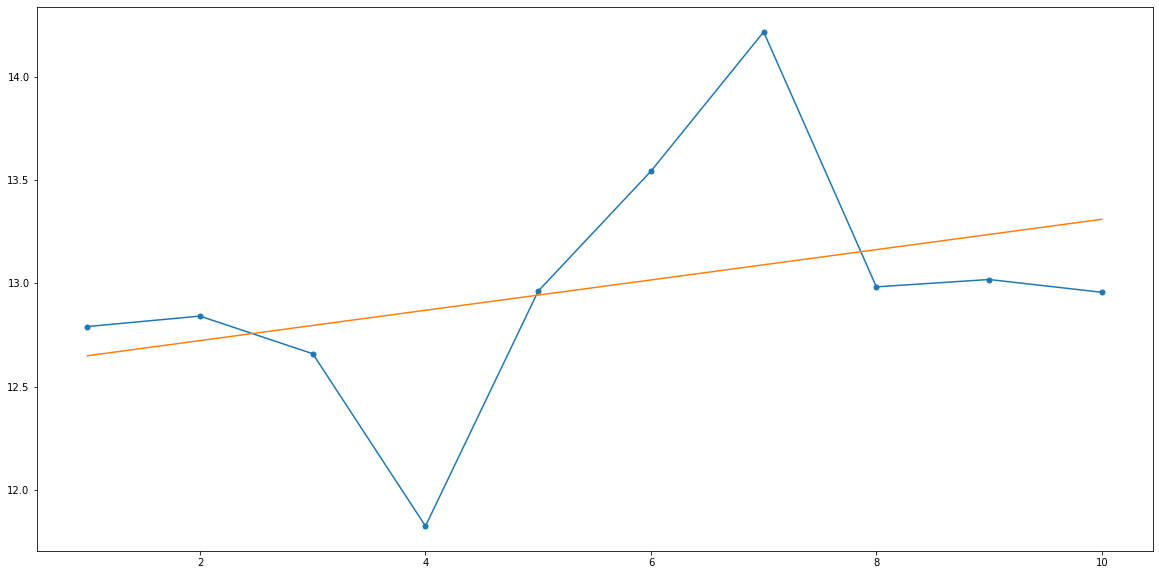

In [7]:
from scipy.stats import linregress 

k, b, r, p, std = linregress(list(range(1, table.shape[0]+1)), table['mean'])

plt.figure(figsize=(20, 10))
x_values = list(range(1, table.shape[0]+1))
plt.plot(x_values, table['mean'], marker='o', ms=5)
plt.plot(x_values, [k*x+b for x in x_values])

print(f'{k=}, {b=}, {r=}, {p=}, {std=}')

In [8]:
carbon_mono = {table.name:table.health[table['SMD100CO'].notna()]['SMD100CO'] for table in records}

distribution = [[name, series.mean(), series.median(), series.std()] for name, series in carbon_mono.items()]

table = pd.DataFrame(columns=['year', 'mean', 'median', 'std'], data=distribution)

table

,year,mean,median,std
0,1999-2000,13.258174,14.0,3.305355
1,2001-2002,13.311927,14.0,3.243919
2,2003-2004,12.868973,13.0,3.326989
3,2005-2006,12.856092,13.0,3.180395
4,2007-2008,13.159529,14.0,3.125326
5,2009-2010,13.494577,14.0,3.233657
6,2011-2012,13.677576,14.0,2.940807
7,2013-2014,13.584541,13.0,2.243648
8,2015-2016,13.460106,13.0,2.229449
9,2017-2018,13.388489,13.0,2.327974


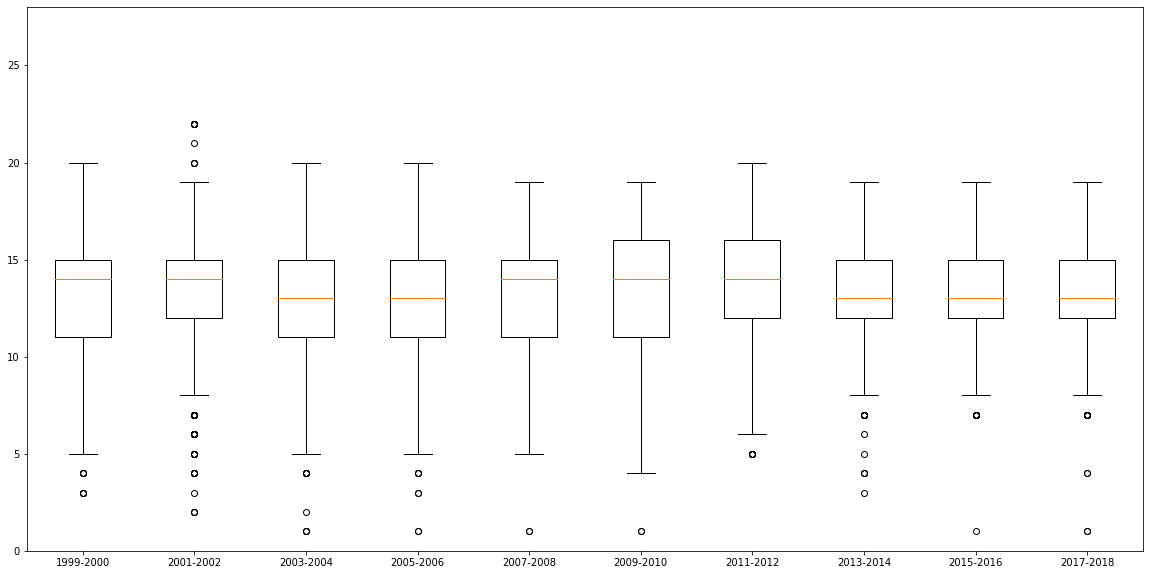

In [9]:
figure, axis = plt.subplots(figsize=(20, 10))

carbon_mono = {table.name:table.health[table['SMD100CO'].notna()]['SMD100CO'] for table in records}

axis.boxplot(carbon_mono.values(), vert=True)
axis.set_xticklabels(carbon_mono.keys())

plt.ylim(0, 28)
plt.show()

k=0.052045081165428095, b=13.019750427007233, r=0.5654345402850895, p=0.0884800995765074, std=0.0268409214181936


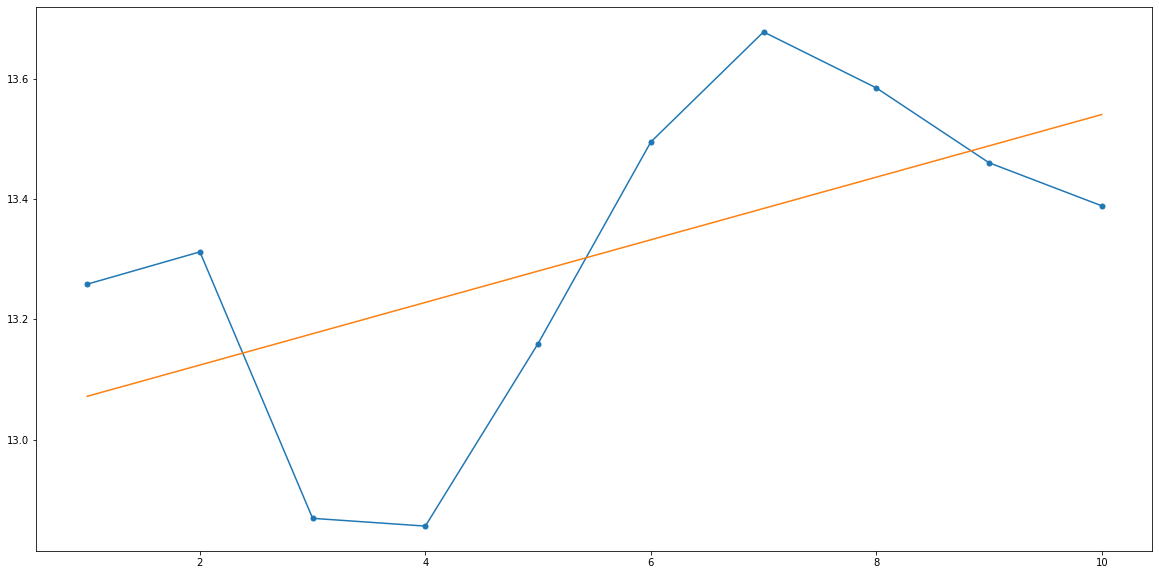

In [10]:
k, b, r, p, std = linregress(list(range(1, table.shape[0]+1)), table['mean'])

plt.figure(figsize=(20, 10))
x_values = list(range(1, table.shape[0]+1))
plt.plot(x_values, table['mean'], marker='o', ms=5)
plt.plot(x_values, [k*x+b for x in x_values])
print(f'{k=}, {b=}, {r=}, {p=}, {std=}')

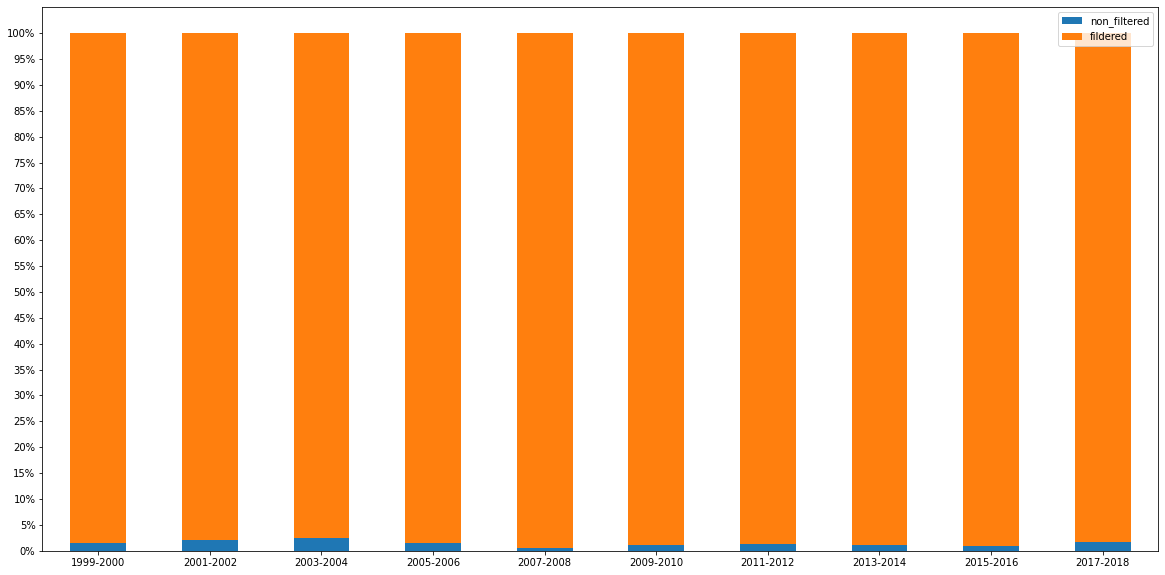

In [11]:
filter_t = [[table.name, (table.health[table.health['SMD100FL'].notna()]['SMD100FL']==1).astype(int)] for table in records]
filter_t = [[name, series.value_counts().to_dict(), series.shape[0]] for name, series in filter_t]
filter_t = [[name, data[0]/size, data[1]/size] for name, data, size in filter_t]

table = pd.DataFrame(columns=['year', 'non_filtered', 'fildered'], data=filter_t)

figure, axis = plt.subplots(figsize=(20, 10))
table.plot.bar(ax=axis, stacked=True)

yticks = np.arange(0, 1.01, 0.05)
plt.yticks(yticks, [f'{number:.0%}' for number in yticks])
plt.xticks(range(table.shape[0]), table['year'], rotation=0)

plt.show()